# Домашняя работа 4. Кластеризация.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #4: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 19.11.2017 00:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 23.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

In [2]:
!pip3 install numpy pandas scipy sklearn matplotlib seaborn Pillow scikit-image

## 1. Изображения (6 баллов)

С помощью алгоритмов кластеризации можно уменьшить число цветов в изображении. В данном случае будут кластеризоваться похожие пиксели. Такой подход позволяет перейти к суперпиксельному представлению изображений, которое является более компактным и используется в задачах компьютерного зрения.

Загрузим картинку `data/bird.jpg` с помощью scikit-image и выведите ее с помощью matplotlib.

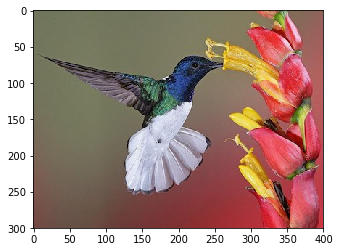

In [1]:
%matplotlib inline
from skimage.io import imread
from matplotlib import pyplot as plt
import numpy as np

img = imread("./data/bird.jpg")
plt.imshow(img)

### 1.1 Scale (0.5 балла)

Если вы посмотрите на содержимое numpy массива, в котором хранится изображение, то увидите, что там будут числа от 0 до 255. Нам лучше перейти к числам от 0 до 1. 

**Преобразуйте вашу матрицу, как сказано выше.**

**Hint**: Это можно сделать с помощью функции `skimage.img_as_float`.

In [2]:
import skimage as sk

iA = sk.img_as_float(img)

### 1.2 Reshape (1 балл)

Мы получили матрицу размера `(300, 400, 3)`. Нам это не подходит. Чтобы запустить kMeans нам нужно иметь много-много объектов и 3 признака - значение яркости пикселя в канале Red, Green и Blue. 

**Преобразуйте матрицу так, чтобы получилась матрица размера `(120000, 3)`. **

**Hint**: Вам пригодятся функции: `np.ravel` и `np.vstack`.

In [3]:
ia = np.ravel(iA)
ia.shape = (120000, 3)

### 1.3 Train (0.5 балла)

Отлично. У нас есть подготовленные данные. Теперь мы будем находить кластеры похожих пикселей по цвету. Для этого создайте KMeans для, например, 8 цветов. **Обучите модель** (может занять около 10 секунд). С помощью магического макроса `%time` **покажите, сколько времени у вас занимало обучение**.

In [8]:
import sklearn
from sklearn.cluster import KMeans
km = KMeans(n_clusters=8)
%time km.fit(ia)

Wall time: 4.95 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### 1.4 Draw centroids (1 балл)

**Нарисуйте с помощью imshow центры кластеров**: будет 8 пикселей со средним цветом по всему кластеру. 
Это называется цветовой палитрой. 

**Hint**: reshape в 3 мерный массив, так как у вас будет 2-мерный

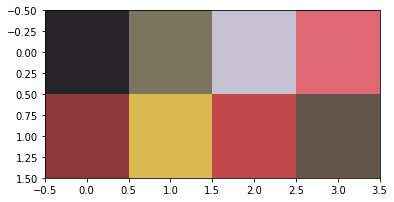

In [9]:
plt.imshow(km.cluster_centers_.reshape(2,4,3))

### 1.5 Draw final image (3 балла)

У нас есть значения цвета для каждого центра кластера. Каждый пиксель в результате обучения KMeans теперь имеет свой лейбл кластера. Значит мы можем заменить все пиксели на соответсвующие им центры класетров. Проведите это преобразование и выведите 8-цветное изображение.

**Hints**: `labels_`, `reshape`, `copy`, логические маски в numpy `arr[arr == 1] = 0`. У меня это 7 строк кода.

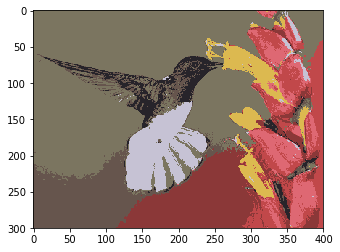

In [10]:
for pix in np.arange(120000):
    ia[pix] = km.cluster_centers_[km.labels_[pix]]
ia.shape = (300,400,3)
plt.imshow(ia)

## 2. Центры кластеров (6 баллов)

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare. Полный датасет доступен здесь: https://archive.org/details/201309_foursquare_dataset_umn. Но в `../../data/checkins.csv.gz` я подготовил данные и оставил только 100000 жлементов, иначе бы KMeans обучался пол дня.

Найдем на Google Maps координаты офисов компании:

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

###  2.0 Read data (0.5 балла): 
**Загрузите датасет `checkins.csv.gz`. Выведите его размер, первые 5 строк таблицы, статистическиую сводку(describe) **

In [12]:
import pandas as pd
dt = pd.read_csv('./data/checkins.csv.gz')
print(dt.size)
dt.head(5)

200000


,latitude,longitude
0,38.895112,-77.036366
1,33.800745,-84.410520
2,45.523452,-122.676207
3,40.764462,-111.904565
4,33.448377,-112.074037


In [13]:
dt.describe()

,latitude,longitude
count,100000.000000,100000.000000
mean,36.886388,-89.396849
std,8.351517,35.579317
min,-45.031162,-159.670833
25%,33.494170,-112.074037
50%,38.646991,-87.743938
75%,40.740389,-75.163789
max,67.631479,174.908056


###  2.1 MeanShift (1 балл): 
Для данной задачи мы не знаем сколько кластеров вообще существует, и есть ли они, поэтому воспользуемся методом, который сам находит нужное количество кластеров. Используйте `MeanShift`, указав `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах. Документацию по нему вы можете найти в документации SKlearn [тут](http://scikit-learn.org/stable/modules/clustering.html#mean-shift).

**Обучите кластеризатор на всех данных.** Выполнение в 4 потока на i5 заняло 2 минуты.

In [ ]:
from sklearn.cluster import MeanShift as ms
ms = ms(bandwidth=0.1, n_jobs=3)
%time ms.fit(dt)

### 2.2 Visualization (0.5 балла): 
**Визуализируйте с помощью matplotlib все точки из датасета** так, чтобы они были разукрашены в соответсвии с кластером к которому они принадлежат. **Добавьте на ваш график ещё точки расположений офисов**, сделайте их большими и красными, чтобы было видно. Рисовать каким-то образом карту мира под точками НЕ надо.

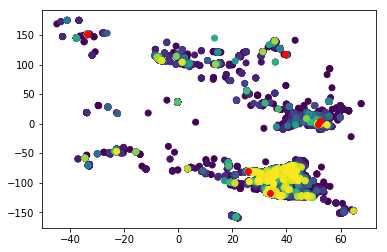

In [182]:
x = dt['latitude']
y = dt['longitude']

of = np.array([[33.751277, -118.188740],
[25.867736, -80.324116],
[51.503016, -0.075479],
[52.378894, 4.885084],
[39.366487, 117.036146],
[-33.868457, 151.205134]])
ofC = of.T

plt.scatter(x, y, c=ms.labels_)
plt.scatter(ofC[0], ofC[1], c='r')

###  2.3 Filter clusters (2 балла): 
Как видим на графике, некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения. 

**Выведите количество кластеров, которое удовлетворяет этому условию.**

**Hint**: `itertools.groupby`

In [158]:
i = 0
currentCluster = 0
countCluster = 0
ms.labels_.sort()
for label in ms.labels_:
    if (label == currentCluster):
        i = i + 1
    else:
        if (i > 15):
            countCluster = countCluster + 1
        i = 1
        currentCluster = label
print(countCluster)

592


###  Задание 2.4 (2 балла): 
Как мы помним, необходимо разместить только 20 баннеров близ офисов компании. Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Выведите эти 20 центров кластеров, отсортрованных по возрастанию расстояния до ближайшего офиса.**

**Hint:** Для вычисления расстояния вы можете использовать обычную евклидову метрику и предполагать, что земля плоская. А можете использовать `geopy.distance.vincenty` если поймёте как.

In [302]:
import sys
dist = []
dB1 = sys.maxsize
for point in ms.cluster_centers_:
    for office in of:
        dB2 = np.sqrt((point[0] - office[0])**2 + (point[1] - office[1])**2)
        if (dB2 < dB1):
            dB1 = dB2
    dist.append(dB1)
    dB1 = sys.maxsize

data = ms.cluster_centers_
dist = np.array([dist])
dist = dist.T
ind = np.arange(3231)
ind = np.array([ind])
ind = ind.T
dist = np.concatenate((ind, dist), axis=1)

[[  0.00000000e+00   1.61437200e+01]
 [  1.00000000e+00   6.19395917e+00]
 [  2.00000000e+00   6.29424146e+00]
 ..., 
 [  3.22800000e+03   3.12067221e+00]
 [  3.22900000e+03   1.20654306e+01]
 [  3.23000000e+03   1.53069485e+01]]


In [ ]:
dist1 = np.column_stack(dist)
dist1 = dist1.T
res = np.concatenate((data, dist1), axis=1)
print(res)
res.sort()
print(res)

Координата центра кластера ближайшего к какому-то из офисов компании должны быть `(52.37296399032261, 4.8923172225806466)`. Если у вас не так, то считайте, что вы сделали что-то неправильно. 